# Poisson equation

We will now investigate solutions to Poisson's equation:

$$
\nabla^2 V(\mathbf{r}) = \sum_i \frac{\partial^2 V}{\partial r_i^2} = -\alpha\rho(\mathbf{r})
$$

for potential $V$ and source density $\rho$. In the case of Coulomb's law, $\rho$ is the charge density and $V$ is the electric potential, with $\alpha = 1/\epsilon_0$.  


We will investigate both **relaxation** and **Fourier** solutions




## Relaxation solutions

As with BVPs, there are relaxation-based solutions in multiple dimensions for PDEs.  For simplicity we will consider Dirichlet boundary conditions such that the potential vanishes along the boundary 

$$V(\mathbf{r_\mathrm{boundary}}) = 0 $$

There are three methods we will investigate

- Jacobi iteration
$$
V_{i,j}^{n+1} = \frac{1}{4} \left( V_{i+1,j}^n + V_{i-1,j}^n + V_{i,j+1}^n + V_{i,j-1}^n + h^2 \rho_{i,j}\right)
$$

- Gauss-Seidel iteration (G-S)
$$
V_{i,j}^{n+1} = \frac{1}{4} \left( V_{i+1,j}^{n+1} + V_{i-1,j}^n + V_{i,j+1}^n + V_{i,j-1}^{n+1} + h^2 \rho_{i,j}\right)
$$

- Successive Over-Relaxation (SOR)
$$
V_{i,j}^{n+1} = (1-\omega)V_{i,j}^n + \frac{\omega}{4} \left( V_{i+1,j}^{n+1} + V_{i-1,j}^n + V_{i,j+1}^n + V_{i,j-1}^{n+1} + h^2 \rho_{i,j}\right)
$$

where $\omega$ is the "over-relaxation" parameter and can be tuned for performance. 

We will investigate the overall rates of convergence to a steady solution, as well as the overall computation time to a steady solution. We will see that the Jacobi solution has the worst performance per iteration, however, it can be vectorized, whereas the other two cannot! As such, despite it converging the slowest, it can achieve a target accuracy faster than the other two due to vectorization. (There is a caveat here, the G-S and SOR implementations are in pure `python`, so cleverer tricks could be done with `C++` loops, however I will not go over a `swig` solution here). 


# Wire Chamber - Solving the Poisson Equation 

In [1]:
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time

In [2]:
# Make the plots a bit bigger to see
# NOTE: Must be done in a separate cell
plt.rcParams['figure.dpi'] = 100

In [3]:
import numpy as np
import time
import cmath

class Poisson :
    def __init__ (self, L, V0, rho_init, method, calcError = True):
        self.V0 = V0               
        self.L = L              # number of interior points in y
        self.omega = 1.88177        # over-relaxation parameter for L = 50
        self.Ny = L + 2             # interior plus two boundary points along Y
        self.Nx = 5*L + 2           # interior plus two boundary points along X
        Nx=self.Nx
        Ny=self.Ny
        self.V = np.zeros( (Ny, Nx) )   # potential to be found
        jj = int(Nx/6)
        ii = int(Ny/2)
        self.V[ii,jj] = self.V0
        self.V[ii,2*jj] = self.V0
        self.V[ii,3*jj] = self.V0
        self.V[ii,4*jj] = self.V0
        self.V[ii,5*jj] = self.V0
        
        self.VNew = np.zeros( (Ny, Nx) )# new potential after each step
        self.h = 2.0 / (L + 1)        # lattice spacing assuming size in x and y = 1
        self.nsmooth = 3              # smoothing steps for multigrid method
        self.rho = np.array( rho_init )
        self.method=method        
        self.calcError = calcError
        self.error  = 0. if self.calcError else None
        self.errors = [] if self.calcError else None


    def __call__(self):
        return getattr(self,self.method)()

    def update(self):
        if self.calcError :
            self.error = np.sum( np.abs(self.V - self.VNew) ) / self.V.size
        self.V[:,:] = self.VNew[:,:]      
        jj = int(Nx/6)
        ii = int(Ny/2)
        self.V[ii,jj] = self.V0
        self.V[ii,2*jj] = self.V0
        self.V[ii,3*jj] = self.V0
        self.V[ii,4*jj] = self.V0
        self.V[ii,5*jj] = self.V0
        if self.calcError :
            self.errors.append(self.error)
            return self.error
        else :
            return None

        
    def Jacobi(self) :
        '''
        Jacobi algorithm for a single iterative step
        '''
        self.VNew = self.JacStep(self.VNew,self.V,self.h,self.rho)
        return self.update()

    def JacStep(self, u, v, h, rho):
        '''
        Jacobi algorithm on arbitrary inputs. Called once by "Jacobi".
        Called many times by "MultiGrid"
        '''
        u[1:-1,1:-1] = np.add.reduce([
            0.25*v[1:-1, 2:] ,
            0.25*v[1:-1, 0:-2],
            0.25*v[2:,   1:-1] ,
            0.25*v[0:-2, 1:-1] ,
            h**2 * rho[1:-1,1:-1]])
        return u

            
    def GaussSeidel(self):
        ''' 
        Gauss-Seidel algorithm for one iterative step
        '''
        self.VNew[:,:] = self.V[:,:]
        # perform Gauss-Seidel update
        for i in range(1, self.L+1):
            for j in range(1, self.L+1):
                self.VNew[i][j] = 0.25 * (self.VNew[i-1][j] + self.VNew[i+1][j] +
                                            self.VNew[i][j-1] + self.VNew[i][j+1] +
                                            self.h**2 * self.rho[i][j])
        return self.update()


    def SuccessiveOverRelaxation(self):
        '''
        Averages between G-S and J methods. 
        '''

        # update even sites in red-black scheme
        for i in range(1, self.L+1):
            for j in range(1, self.L+1):
                if (i + j) % 2 == 0:
                    self.VNew[i][j] = (1 - self.omega) * self.V[i][j] + self.omega / 4 * (
                                 self.V[i-1][j] + self.V[i+1][j] + self.V[i][j-1] +
                                 self.V[i][j+1] + self.h**2 * self.rho[i][j] )

        # update odd sites in red-black scheme
        for i in range(1, self.L+1):
            for j in range(1, self.L+1):
                if (i + j) % 2 != 0:
                    self.VNew[i][j] = (1 - self.omega) * self.V[i][j] + self.omega / 4 * (
                                 self.VNew[i-1][j] + self.VNew[i+1][j] + self.VNew[i][j-1] +
                                 self.VNew[i][j+1] + self.h**2 * self.rho[i][j] )
        return self.update()


    def FFT(self):
        '''
        Explicitly solves differential equation in Fourier domain
        '''
        
        # Make a grid to get indices
        x = np.arange(self.N)
        y = np.arange(self.N)
        xx,yy = np.meshgrid(x,y)
        # Construct root of unity
        i = 0. + 1.j
        W = cmath.exp( 2 * i * cmath.pi / float(self.N) )
        # Get the denominator using the grid
        d = 4.0 - np.power(W, xx ) - np.power(W, -xx) - np.power(W, yy) - np.power(W, -yy)
        valid_d = (d > 0.0)
        # FFT of rho columns
        rhof = np.fft.fft(self.rho, axis=0)
        # FFT of rho rows
        rhof = np.fft.fft(rhof,axis=1)
        # Solve for V in Fourier domain
        Vf = np.divide( rhof * self.h**2, d, out=np.zeros_like(d, dtype=complex), where=np.absolute(d)>0)
        # IFFT of V rows
        self.V = np.fft.ifft( Vf, axis=0)
        # IFFT of V columns
        self.V = np.fft.ifft( self.V, axis=1)
        return 



For the relaxation simulations, we will put a point charge in the center of a "grounded box" (Dirichlet boundary conditions) and allow the solution to converge. We will first plot the wavefunction as determined by the Jacobi method (the others look almost identical). 

In [4]:
L = 100
q = 0                # point charge
Nx = 5*L + 2
Ny = L+2
h = 2.0/(L+1)
rho = np.zeros((Ny,Nx))
V0 = 5
#print(rho)
nsteps = 100
steps = np.arange(nsteps)
p = Poisson(L, V0, rho, 'Jacobi')
for i in steps : 
    p()

    
    

#print(np.shape(p.V))

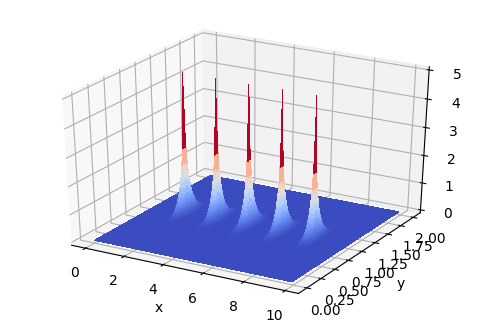

In [5]:
#%matplotlib notebook
# Define the axes 
x = np.arange(0, p.h*(p.L+2), p.h)
y = np.arange(0, p.h*(5*p.L+2), p.h)
#print(np.shape(x))
#print(np.shape(y))
#print(x,y)
# Get the grid
X, Y = np.meshgrid(y,x)
#print(np.shape(X))
#print(np.shape(Y))
# Set Z to the poisson V[i][j]
Z = np.array( p.V )
#print(np.shape(Z))
fig = plt.figure(1)
ax = fig.gca(projection='3d')
sur = ax.plot_surface( X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False )
plt.xlabel("x")
plt.ylabel("y")

plt.show()

# Analysis 

Potential form is accurate. We have very high positive values at points were the wire passes the plane. 

# Compute Trajectory of the Charged Particle  

In [6]:
m = 1.0
Q = 10.0
# Intial position of the Charge particle
x0 = 4.0
y0 = 1.0
# Initial velocity of the Charged particle
vx0 = 1.0
vy0 = 1.0
# Computing acceleration 
t = np.linspace(0.0,10.0,100)

#print(np.shape(p.V))
#print(p.h)
Xt = []
Yt = []
vxi = vx0
vyi = vy0
xi = x0
yi = y0
for dt in t:
    iy = int(xi/p.h)
    ix = int(yi/p.h)
    #print(ix,iy)
    if(iy > Ny or iy < 0 or ix > Nx or ix < 0):
        #break
        ax = 0
        ay = 0
    else:    
        ax = -(Q/m)*(p.V[ix,iy - 2] - 8*p.V[ix,iy-1] + 8*p.V[ix,iy+1] - p.V[ix,iy+2])/(12.0*p.h)
        ay = -(Q/m)*(p.V[ix - 2,iy] - 8*p.V[ix-1,iy] + 8*p.V[ix+1,iy] - p.V[ix+2,iy])/(12.0*p.h)
    
    xt = xi + vxi*dt + 0.5*dt*dt*ax
    yt = yi + vyi*dt + 0.5*dt*dt*ay
    vxt = vxi + dt*ax
    vyt = vyi + dt*ay
    xi = xt
    yi = yt
    vxi = vxt
    vyi = vyt
    #print(xt,yt)
    Xt.append(xi)
    Yt.append(yi)
    

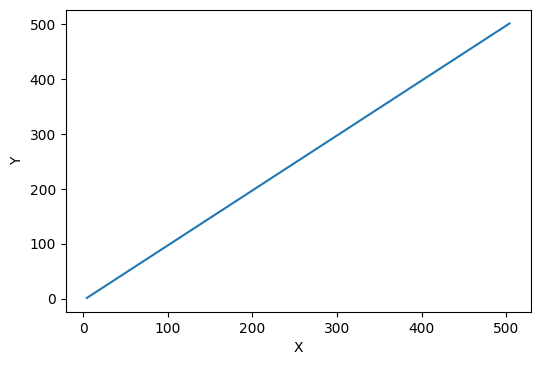

In [7]:
plt.plot(Xt,Yt)
plt.xlabel("X")
plt.ylabel("Y")

plt.show()

# Analysis  
We the path to compute the trajectory is accurate. However the big road block is computing the derivative at the boundary values and further computing the trajectory. In this case the particle is thrown away if it hits the boundary. 